In [1]:
from PIL import Image
import nibabel
import os, pathlib, numpy, json
import h5py
from fenics import *
from fenics_adjoint import *

In [2]:
datadir = pathlib.Path("/home/bastian/Oscar-Image-Registration-via-Transport-Equation/testdata_2d")

In [3]:
hyperparameters = {}
hyperparameters["state_functiondegree"] = 1
hyperparameters["state_functionspace"] = "DG"

In [4]:
hyperparameters["normalize"] = True

In [5]:
hyperparameters["image"] = str(datadir / "input.mgz")

In [6]:
def read_image(hyperparameters, name, mesh=None, printout=True, normalize=True, degree=0):
    
    if hyperparameters[name].endswith(".mgz"):
        image2 = nibabel.load(hyperparameters[name])
        data = image2.get_fdata()
    elif hyperparameters[name].endswith(".png"):
        img = Image.open(hyperparameters[name])
        img = img.convert("L")
        data = np.array(img)
        data = np.expand_dims(data, -1)

    
    if printout:
        print("dimension of image:", data.shape, "(", data.size, "voxels)")


    # data = np.swapaxes(data, 1, 0)

    nx = data.shape[0] 
    ny = data.shape[1]
    nz = data.shape[2]
    hyperparameters[name + ".shape"] = list(data.shape)

    if mesh is None:
        if nz == 1:
            mesh = UnitSquareMesh(MPI.comm_world, nx, ny)
        else:
            mesh = UnitCubeMesh(MPI.comm_world, nx, ny, nz)

    space = FunctionSpace(mesh, hyperparameters["state_functionspace"], 
                         degree,
                          #hyperparameters["state_functiondegree"]
                         )
    u_data = Function(space)

    xyz = space.tabulate_dof_coordinates().transpose()

    xyz[0, :] *= (nx - 1)
    xyz[1, :] *= (ny - 1)
    
    if nz > 1:
        xyz[2, :] *= (nz - 1)

    else:
        xyz2 = np.zeros((3, xyz.shape[1]))
        xyz2[0, :] = xyz[0, :]
        xyz2[1, :] = xyz[1, :]
        xyz = xyz2
        del xyz2

    i, j, k = np.rint(xyz).astype("int")
    u_data.vector()[:] = data[i, j, k]

    if normalize:
        if printout:
            print("Normalizing image")
            print("Img.vector()[:].max()", u_data.vector()[:].max())

        u_data.vector()[:] *= 1 / u_data.vector()[:].max()

        if printout:
            print("Applying ReLU() to image")
        
        u_data.vector()[:] = np.where(u_data.vector()[:] < 0, 0, u_data.vector()[:])
    
    space = FunctionSpace(mesh, hyperparameters["state_functionspace"], hyperparameters["state_functiondegree"])
        
    u_data = project(u_data, space)
    return mesh, u_data, 1

In [7]:
def Pic2FEM(FName, mesh=None, degree=0, color=False, normalize=True):
    if FName.endswith("mgz"):
        import nibabel
        myarray=nibabel.load(FName).get_fdata()[:,:, 0]
        myarray = myarray / np.max(myarray)
        img = Image.fromarray(np.uint8(myarray*255))
        img = img.convert("RGB")
    else:
        img = Image.open(FName)
    xPixel = np.shape(img)[0]
    yPixel = np.shape(img)[1]
    
    #which of the color channels to process
    if color:
        Channels = (0,1,2)
        img.convert("RGB")
    else:
        Channels = (0,)
        img.convert("L")        
    
    if mesh == None:
        mesh = RectangleMesh(MPI.comm_world, Point(0.0, 0.0), Point(img.size[0], img.size[1]), int(img.size[0]), int(img.size[1]), "right")
    
    #Key mapping between global vertex index (input) and (i,j) pixel coordinate (output)
    #needs to be changed if the diagonal is not "right"
    PixID = np.zeros([2*img.size[0]*img.size[1], 2], dtype="uint")
    for i in range(img.size[0]):
        for j in range(img.size[1]):
            #print "init:", i, j
            PixID[2*(img.size[0]*j + i)+0, 0] = img.size[1] - 1 - j
            PixID[2*(img.size[0]*j + i)+1, 0] = img.size[1] - 1 - j
            PixID[2*(img.size[0]*j + i)+0, 1] = i
            PixID[2*(img.size[0]*j + i)+1, 1] = i
    
    if color:
        ImgSpace = VectorFunctionSpace(mesh, "DG", degree, len(Channels))
    else:
        ImgSpace = FunctionSpace(mesh, "DG", degree)
        
    ImgFunction = Function(ImgSpace)
    ImgFunction.rename("image", "")
    Fvalues = np.zeros(ImgFunction.vector().local_size())
        
    for chan in Channels:
        if color:
            ImgDofs = ImgSpace.sub(chan).dofmap()
            cData = np.array(img.getchannel(chan))
        else:
            ImgDofs = ImgSpace.dofmap() #tabulate_dof_coordinates()
            cData = np.array(img.getchannel(chan))
        
        for c in cells(mesh):
            #local and global index of cell
            LID = c.index()
            GID = c.global_index()
            #local dof in DG0 function
            FID = ImgDofs.cell_dofs(c.index())[0]
            #get grey value from image
            MyGrey = cData[PixID[GID, 0], PixID[GID, 1]]
            #map 0..255 grey steps to [0,1]
            normval = 1
            if normalize:
                normval = 255.0
            fValue = MyGrey/(normval)
            Fvalues[FID] = fValue

    #Set function values
    ImgFunction.vector().set_local(Fvalues)
    ImgFunction.vector().apply("")

    return mesh, ImgFunction, len(Channels)

In [8]:
FName2 = str(hyperparameters["image"])

rawF = nibabel.load(FName2).get_fdata()

if hyperparameters["normalize"]:
    rawF /= np.max(rawF)

    rawF = np.where(rawF < 0, 0, rawF)

In [9]:
mymesh, my_img, channels = read_image(hyperparameters, name="image", mesh=None, printout=True, normalize=hyperparameters["normalize"])
mymesh1, my_img1, channels1 = read_image(hyperparameters, name="image", mesh=None, printout=True, normalize=hyperparameters["normalize"], degree=1)

dimension of image: (16, 22, 1) ( 352 voxels)
Normalizing image
Img.vector()[:].max() 0.9367520809173584
Applying ReLU() to image
dimension of image: (16, 22, 1) ( 352 voxels)
Normalizing image
Img.vector()[:].max() 0.9367520809173584
Applying ReLU() to image
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [10]:
fenmesh, fen_img1, fenchannels = Pic2FEM(FName=hyperparameters["image"], 
                                         color=False, normalize=hyperparameters["normalize"],
                                         mesh=None, degree=0)#hyperparameters["state_functiondegree"])

In [11]:
Space = FunctionSpace(fenmesh, hyperparameters["state_functionspace"], hyperparameters["state_functiondegree"])
# fen_img = project(sqrt(inner(fen_img1, fen_img1)), Space)
fen_img = project(fen_img1, Space)

In [12]:
if hyperparameters["normalize"]:
    pass
    #fen_img.vector()[:] /= fen_img.vector()[:].max()
    #fen_img.vector()[:] = np.where(fen_img.vector()[:] < 0, 0, fen_img.vector()[:])

In [13]:
np.sum(np.isnan(fen_img.vector()[:]))

0

In [14]:
print(fen_img.vector()[:].min(), fen_img.vector()[:].max())
print(my_img.vector()[:].min(), my_img.vector()[:].max())

0.0 1.0000000000000013
0.0 1.000000000000001


In [15]:
print(np.mean(rawF))

print(assemble(fen_img1*dx(domain=fenmesh)) / assemble(1*dx(domain=fenmesh)))
print(assemble(fen_img*dx(domain=fenmesh)) / assemble(1*dx(domain=fenmesh)))
print(assemble(my_img*dx(domain=mymesh)) / assemble(1*dx(domain=mymesh)))
print(assemble(my_img1*dx(domain=mymesh1)) / assemble(1*dx(domain=mymesh1)))

0.09704711909028453
0.0963903743315508
0.09639037433155086
0.09718642814074238
0.1347476097712265


In [29]:
print(assemble((my_img1-my_img)*dx(domain=mymesh1)))
print(assemble((fen_img-fen_img1)*dx(domain=fenmesh)))

0.03592449675768093
Calling FFC just-in-time (JIT) compiler, this may take some time.
1.7014167852380524e-14


In [16]:
print(fenmesh.num_cells(), fenmesh.num_vertices())
print(mymesh.num_cells(), mymesh.num_vertices())

704 391
704 391


In [17]:
print(fen_img1.function_space())
print(fen_img.function_space())
print(my_img.function_space())

FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 58), FiniteElement('Discontinuous Lagrange', triangle, 0))
FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 58), FiniteElement('Discontinuous Lagrange', triangle, 1))
FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0), FiniteElement('Discontinuous Lagrange', triangle, 1))


In [18]:
print(fen_img1.function_space().tabulate_dof_coordinates().shape)
print(fen_img.function_space().tabulate_dof_coordinates().shape)
print(my_img.function_space().tabulate_dof_coordinates().shape)

(704, 2)
(2112, 2)
(2112, 2)


In [19]:
print(fen_img.vector()[:].shape)
print(my_img.vector()[:].shape)

(2112,)
(2112,)


In [20]:
my_img.function_space().tabulate_dof_coordinates().max()#.transpose().shape

1.0

In [21]:
rawF.shape

(16, 22, 1)

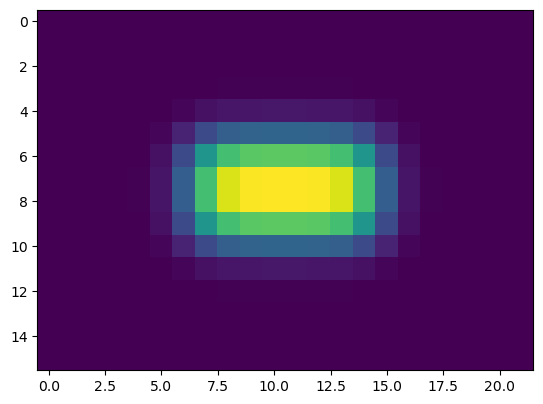

In [22]:
plt.imshow(rawF)

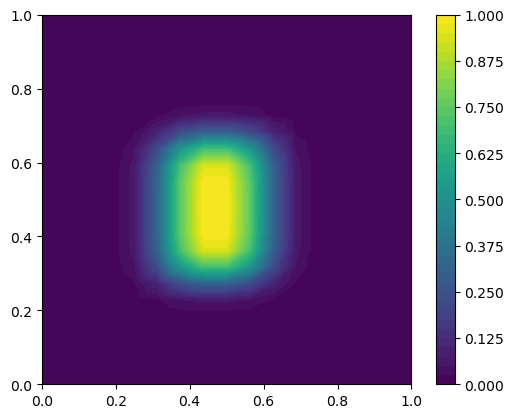

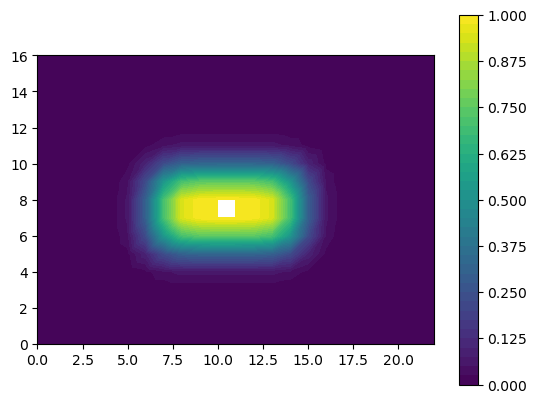

In [23]:
ax = plot(my_img)
plt.colorbar(ax)
plt.show()

ax = plot(fen_img)
plt.colorbar(ax)
plt.show()